# Car Purchase Intention Prediction

### This notebook walks through the process of building a machine learning model to predict whether a customer intends to buy a car based on their annual salary, age, and other features.

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [25]:
file_path = 'car_data.csv'
car_data = pd.read_csv(file_path)
car_data

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0
...,...,...,...,...,...
995,863,Male,38,59000,0
996,800,Female,47,23500,0
997,407,Female,28,138500,1
998,299,Female,48,134000,1


In [26]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [27]:
# Check for duplicates
duplicates = car_data.duplicated().sum()
print(f'Duplicates: {duplicates}')

Duplicates: 0


In [28]:
# Summary statistics to check for outliers
summary_stats = car_data.describe()
print(summary_stats)

           User ID          Age   AnnualSalary    Purchased
count  1000.000000  1000.000000    1000.000000  1000.000000
mean    500.500000    40.106000   72689.000000     0.402000
std     288.819436    10.707073   34488.341867     0.490547
min       1.000000    18.000000   15000.000000     0.000000
25%     250.750000    32.000000   46375.000000     0.000000
50%     500.500000    40.000000   72000.000000     0.000000
75%     750.250000    48.000000   90000.000000     1.000000
max    1000.000000    63.000000  152500.000000     1.000000


Text(0.5, 1.0, 'Age Distribution')

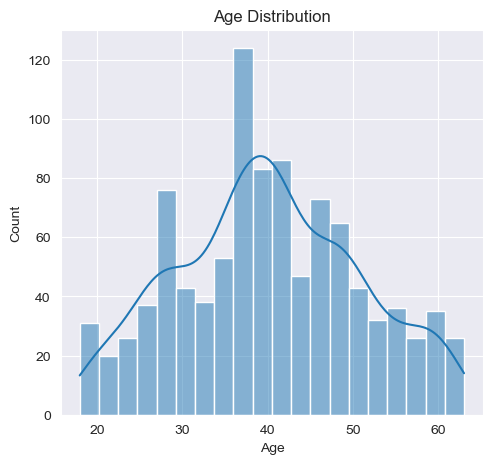

In [29]:
# Plot distribution of Age
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(car_data['Age'], kde=True, bins=20)
plt.title('Age Distribution')

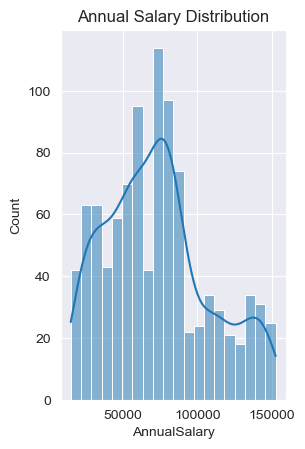

In [30]:
# Plot distribution of Annual Salary
plt.subplot(1, 2, 2)
sns.histplot(car_data['AnnualSalary'], kde=True, bins=20)
plt.title('Annual Salary Distribution')

plt.show()

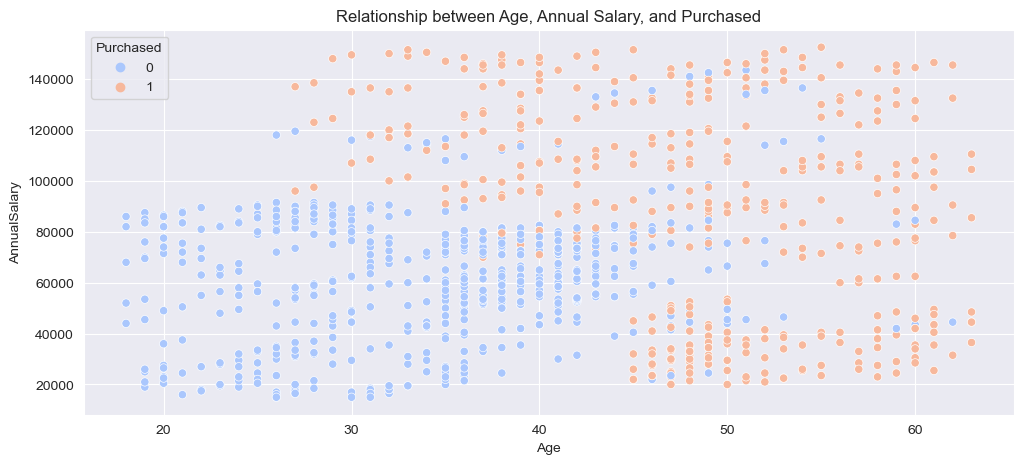

In [31]:
# Relationship between Age, Annual Salary, and Purchased
plt.figure(figsize=(12, 5))
sns.scatterplot(data=car_data, x='Age', y='AnnualSalary', hue='Purchased', palette='coolwarm')
plt.title('Relationship between Age, Annual Salary, and Purchased')
plt.show()

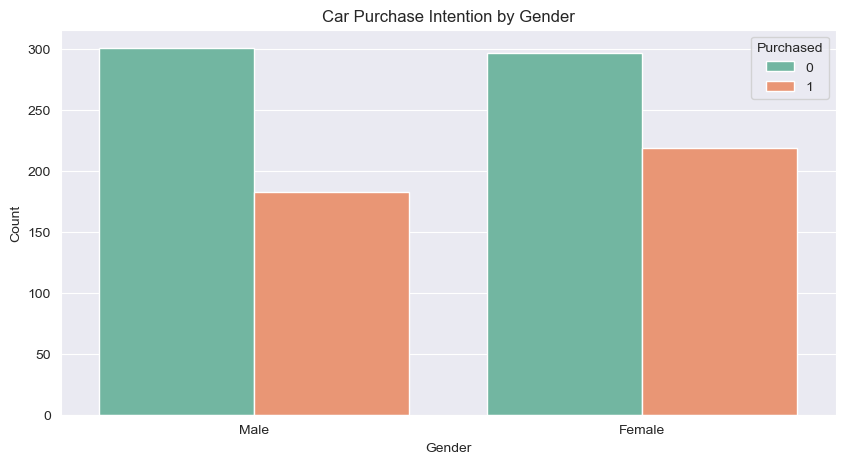

In [32]:
# Does gender influence the intention to purchase a car?
plt.figure(figsize=(10, 5))
sns.countplot(x='Gender', hue='Purchased', data=car_data, palette='Set2')
plt.title('Car Purchase Intention by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Purchased', loc='upper right')
plt.show()

In [33]:
# Feature Engineering - Binning Age into categories
car_data['AgeBin'] = pd.cut(car_data['Age'], bins=[18, 30, 40, 50, 63], labels=['18-30', '31-40', '41-50', '51-63'])
car_data

,User ID,Gender,Age,AnnualSalary,Purchased,AgeBin
0,385,Male,35,20000,0,31-40
1,681,Male,40,43500,0,31-40
2,353,Male,49,74000,0,41-50
3,895,Male,40,107500,1,31-40
4,661,Male,25,79000,0,18-30
...,...,...,...,...,...,...
995,863,Male,38,59000,0,31-40
996,800,Female,47,23500,0,41-50
997,407,Female,28,138500,1,18-30
998,299,Female,48,134000,1,41-50


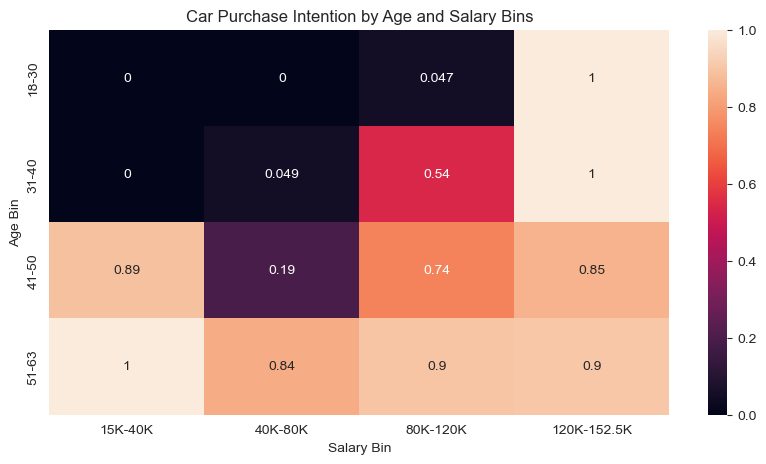

In [34]:
# What is the distribution of customers who intend to purchase a car across different salary and age bins?
# Binning Age and Annual Salary
car_data['AgeBin'] = pd.cut(car_data['Age'], bins=[18, 30, 40, 50, 63], labels=['18-30', '31-40', '41-50', '51-63'])
car_data['SalaryBin'] = pd.cut(car_data['AnnualSalary'], bins=[15000, 40000, 80000, 120000, 152500], labels=['15K-40K', '40K-80K', '80K-120K', '120K-152.5K'])

plt.figure(figsize=(10, 5))
sns.heatmap(pd.crosstab(car_data['AgeBin'], car_data['SalaryBin'], values=car_data['Purchased'], aggfunc='mean'), annot=True)
plt.title('Car Purchase Intention by Age and Salary Bins')
plt.xlabel('Salary Bin')
plt.ylabel('Age Bin')
plt.show()

In [35]:
# Encoding Gender

gender_encoder = LabelEncoder()
age_bin_encoder = LabelEncoder()

car_data['Gender'] = gender_encoder.fit_transform(car_data['Gender'])
car_data['AgeBin'] = age_bin_encoder.fit_transform(car_data['AgeBin'])

# Drop User ID column as it's not useful for prediction
car_data.drop(columns=(['User ID', 'SalaryBin']), axis=1, inplace=True)
car_data

,Gender,Age,AnnualSalary,Purchased,AgeBin
0,1,35,20000,0,1
1,1,40,43500,0,1
2,1,49,74000,0,2
3,1,40,107500,1,1
4,1,25,79000,0,0
...,...,...,...,...,...
995,1,38,59000,0,1
996,0,47,23500,0,2
997,0,28,138500,1,0
998,0,48,134000,1,2


In [36]:
# Splitting the dataset into features (X) and target (y)
X = car_data.drop('Purchased', axis=1)
y = car_data['Purchased']

In [37]:
# Scaling numeric features
scaler = StandardScaler()
X[['Age', 'AnnualSalary']] = scaler.fit_transform(X[['Age', 'AnnualSalary']])

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

In [38]:
# Evaluating Logistic Regression
print("Logistic Regression Performance:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")

Logistic Regression Performance:
[[106   6]
 [ 31  57]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       112
           1       0.90      0.65      0.75        88

    accuracy                           0.81       200
   macro avg       0.84      0.80      0.80       200
weighted avg       0.83      0.81      0.81       200

Accuracy: 0.815


In [39]:
# Applying Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Evaluating Random Forest Classifier
print("Random Forest Classifier Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Classifier Performance:
[[106   6]
 [ 12  76]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       112
           1       0.93      0.86      0.89        88

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 0.91


In [40]:
# Cross-validation for Logistic Regression
cv_scores_log = cross_val_score(log_reg, X, y, cv=10)
print(f"Logistic Regression CV Accuracy: {cv_scores_log.mean()}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_clf, X, y, cv=10)
print(f"Random Forest CV Accuracy: {cv_scores_rf.mean()}")

Logistic Regression CV Accuracy: 0.835
Random Forest CV Accuracy: 0.8940000000000001


# Testing

In [41]:
# dummy data
new_data = pd.DataFrame({
    'Gender': ['Male', 'Female'],
    'Age': [29, 45],
    'AnnualSalary': [50000, 120000]
})

new_data

,Gender,Age,AnnualSalary
0,Male,29,50000
1,Female,45,120000


In [42]:
# Processing
new_data['AgeBin'] = pd.cut(new_data['Age'], bins=[18, 30, 40, 50, 63], labels=['18-30', '31-40', '41-50', '51-63'])
new_data

,Gender,Age,AnnualSalary,AgeBin
0,Male,29,50000,18-30
1,Female,45,120000,41-50


In [43]:
# Encoding Gender
new_data['Gender'] = gender_encoder.transform(new_data['Gender'])
new_data['AgeBin'] = age_bin_encoder.transform(new_data['AgeBin'])

new_data

,Gender,Age,AnnualSalary,AgeBin
0,1,29,50000,0
1,0,45,120000,2


In [44]:
# Scaling Age and Annual Salary
new_data[['Age', 'AnnualSalary']] = scaler.transform(new_data[['Age', 'AnnualSalary']])

# Predicting using the trained RandomForest model
new_predictions_rf = rf_clf.predict(new_data)

# Predicting using the trained Logistic Regression model
new_predictions_log = log_reg.predict(new_data)

# Output the predictions
print(f"Random Forest Predictions: {new_predictions_rf}")
print(f"Logistic Regression Predictions: {new_predictions_log}")

Random Forest Predictions: [0 1]
Logistic Regression Predictions: [0 1]
